## Monte Carlo Option Pricing Example Using CLT Confidence Intervals
This MATLAB script shows how to use approximate Central Limit Theorem
(CLT) confidence intervals with Monte Carlo to price a financial
derivative or option.  See **OptionPricingExample** for some of the
background of this example.


In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

### Plot historical data
Here we load in the historical adjusted daily closing prices of a stock and plot the most recent year's data.  The data were obtained from <http://finance.yahoo.com> for GOOG for the period ending May 19, 2015.

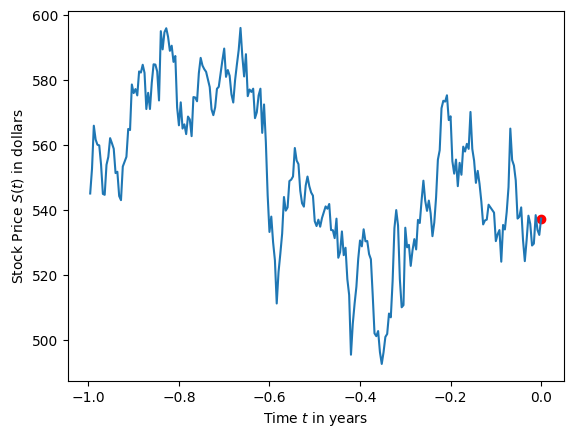

In [2]:
# Load the data into a NumPy array
data = np.loadtxt('stockPriceHistory.txt')
S0 = data[len(data)-1] # stock price today
Delta = 1/250 # daily time increment in years
timeBefore = np.arange(-249, 1) * Delta  #daily monitoring for one year prior to today
plt.plot(timeBefore, data) # plot history
plt.scatter(0,S0,color = 'red') # plot initial price
plt.xlabel('Time $t$ in years')
plt.ylabel('Stock Price $S(t)$ in dollars')
plt.show()

### Estimate drift and volatility
Although we know the past, we do not know the future.  However, we can
use historical data to build a random (stochastic) model of the future.
Let $S(t)$ denote the price of this stock at time $t$ measured in
years.  The geometric Brownian motion model of a stock price says that 
 
$$ S(t+\Delta ) = S(t) \exp( \Delta m + \sigma \sqrt{\Delta} Z ), $$

where 

* $\Delta = 1/250$ is the _time increment_ (250 trading days per year), 
* $m$ is a constant _drift_, 
* $\sigma$ is the constant _volatility_, and 
* $Z$ is a Gaussian (normal) random variable with zero mean and unit variance. 

For the data that we have,$(t_j,S(t_j)),\ j=-249, -248, \ldots, 0$,
the relationship between stock prices at successive times can be written
as

$$ \log\biggl(\frac{S(t_{j+1})}{S(t_{j})} \biggr) = \log(S(t_{j+1} )) -
\log(S(t_j)) = \Delta m + \sigma \sqrt{\Delta} Z_j, $$

where the $Z_j$ are independent and identically distributed (IID)
$\mathcal{N}(0,1)$.  This means that we can estimate $\Delta m$ and
$\sigma^2 \Delta$ by the sample mean and variance of the difference of the logged stock price data:

$$ \Delta m  = \frac{1}{249} \sum_{j=-249}^{-1}
 \log\biggl(\frac{S(t_{j+1})}{S(t_{j})} \biggr), \qquad  \sigma^2 \Delta =
 \frac{1}{248} \sum_{j=-249}^{-1}
 \biggl[\log\biggl(\frac{S(t_{j+1})}{S(t_{j})} \biggr) - \Delta m
 \biggr]^2, \qquad t_j = \frac{j}{250}.$$

In [3]:
diffLogStockPrice = np.diff(np.log(data)) # difference of the log of the stock prices
scDrift = np.mean(diffLogStockPrice) # sample mean
drift = scDrift/Delta # estimated drift
scVolatility = np.std(diffLogStockPrice,ddof=1)  # sample standard deviation
volatility = scVolatility/np.sqrt(Delta) # estimated volatility
print("The estimated drift is ",f"{drift:.4f}", "and volatility is", f"{volatility:.4f}")

The estimated drift is  -0.0143 and volatility is 0.1965


### Simulating European call option payoffs
In |OptionPricingExample| we plotted asset paths monitored daily out for
half a year.  However, for pricing the European call option, we only need
the price at the expiry time, \(T\), of a half year later, not at the
times in between.  This simplifies the Monte Carlo simulation and reduces
the time required.

This function generates $n$ stock prices at the final time

In [4]:
timeFinal = 1/2 # final time
SVal = lambda n: S0*np.exp(drift*timeFinal + volatility*np.sqrt(timeFinal)*np.random.randn(n,1))

This function generates $n$ discounted payoffs

In [5]:
K = 600 # strike price
interest = drift + volatility**2/2 # interest rate
euroCallPayoff = lambda n: np.maximum(SVal(n) - K, 0) * np.exp(-interest * timeFinal) #discounted payoffs

Now we plot an empirical distribution of those discounted payoffs, which
is an approximation to the cumulative distribution function of the random
variable $Y = $ discounted payoff

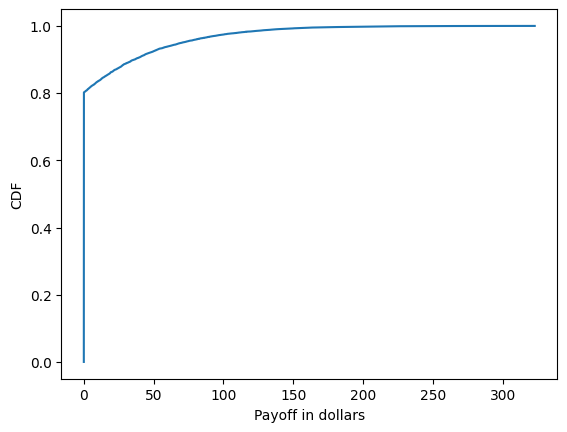

In [6]:
n = int(1e4) # number of payoffs to plot
payoffs = euroCallPayoff(n)  # generate n payoffs
sortedpay = np.sort(payoffs,axis =0)  # sort them
plt.plot(sortedpay,(np.arange(1, n + 1)-1/2)/n) # plot the empirical distribution function scenarios
plt.xlabel('Payoff in dollars')
plt.ylabel('CDF')
plt.show()

### Computing the European call option price to a desired accuracy
The European call option is the expected value of the payoff, i.e.,

$$ \text{fair price} = \mu = \mathbb{E}(Y) = \mathbb{E}(\text{discounted payoff}). $$

We want a fixed width confidence interval, i.e., given an absolute error
tolerance $\varepsilon_{\text{a}}$ and a relative error tolerance
$\varepsilon_{\text{r}}$ we want to find $\hat{\mu}$ such that

$$ \mathbb{P}[|\mu - \hat{\mu}| \le \max(\varepsilon_{\text{a}},
 \varepsilon_{\text{r}}|\mu|) \ge 99\%. $$

Using the Central Limit Theorem we can compute an approximate confidence
interval like that above by the GAIL function **meanMC_CLT**.

In [10]:
absTol = 1e-1 # 10 cents absolute error
relTol = 0 # no relative error
alpha = 0.01 # Uncertainty 
start = time.time()
euroCallPrice,nSample = meanMC_CLT(euroCallPayoff,absTol,relTol,alpha)
end = time.time()
print("After generating", f"{int(nSample):,}, ",
      "asset paths, we have the option price = $",f"{ euroCallPrice:6.3f}"," with the tolerance $", f"{ absTol:6.3f}")
print("The elpased time is {}".format(end-start))

After generating 841,889,  asset paths, we have the option price = $  9.843  with the tolerance $  0.100
The elpased time is 0.045966148376464844


There is an exact formula for the price of a European call option:

\begin{align*}
 \text{fair price} & = \mu \\
 & = S(0) \Phi \left(\frac{\log(S(0)/K) + (r + \sigma^2/2)T}{\sigma \sqrt{T}} \right)\\
 & \qquad \qquad  -Ke^{-rT} \Phi \left(\frac{\log(S(0)/K) + (r - \sigma^2/2)T}{\sigma \sqrt{T}} \right)
 \end{align*}

where $\Phi$ is the CDF of the standard Gaussian random variable.  For this set of parameters is

In [11]:
trueEuroCallPrice = S0 * norm.cdf((np.log(S0/K) + (interest + volatility**2/2)*timeFinal)/(volatility * np.sqrt(timeFinal))) \
    - K * np.exp(-interest * timeFinal) * norm.cdf((np.log(S0/K)  + (interest - volatility**2/2)*timeFinal)/(volatility * np.sqrt(timeFinal)))
print("The exact price = $",f"{ trueEuroCallPrice:6.3f}")

The exact price = $  9.879


Our Monte Carlo approximation is within $\pm \$0.1$ of the true price.

We can also set a pure relative error criterion of 5 cents on 10 dollars:

In [12]:
absTol = 0 # No absolute error
relTol = 0.005 # 0.5% relative error
start = time.time()
euroCallPrice,nSample = meanMC_CLT(euroCallPayoff,absTol,relTol,alpha)
end = time.time()
print("After generating", f"{int(nSample):,}, ",
      "asset paths, we have the option price = $",f"{ euroCallPrice:6.3f}"," with the relative tolerance", f"{ relTol:6.3f}")
print("The elpased time is {}".format(end-start))

After generating 295,634,636,  asset paths, we have the option price = $  9.880  with the relative tolerance  0.005
The elpased time is 12.12537169456482


Now our Monte Carlo approximation is within $\pm 0.005 \times \$9.889 =\pm \$0.05$ of the true price.

#### meanMC_CLT function

In [7]:
def meanMC_CLT(inputRandomFuc,absTol,relTol,alpha): #Simple version of meanMC_CLT
    nsig = 1000 # initial size of the sample
    inflate = 1.2 # inflation rate
    YY = inputRandomFuc(nsig)
    sigma  = np.std(YY,ddof = 1)
    hum = np.mean(YY)
    sigmaUpBound = sigma * inflate #upper ound on the standard deviation
    nmu = max(1, np.power(np.ceil(norm.ppf(1-alpha/2)*sigmaUpBound/max(absTol,relTol)),2).astype(int) )  # number of samples needed for the error tolerance
    mu = np.mean(inputRandomFuc(nmu))
    nSample = nsig + nmu
    return mu, nSample